# Variational Autoencoder

# Prerequirements

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider,IntSlider

from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


# Load MNIST Datasets

In [3]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

Reshape and normalize the data

In [4]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train / x_train.max()

x_test -= x_test.min()
x_test = x_test / x_test.max()

# Build VAE

Define the Encoder and Decoder.

In [5]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

h_input = Input(shape=(2,))

Define the sampling function.

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [8]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [9]:
VAE = Model(x,x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

Define loss function

In [10]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

Compile VAE & load the weight from VAE_handwriting_model_weights.h5

In [11]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.load_weights('NCTS_MODEL/VAE_handwriting_model_weights.h5')

# VAE Encoder

In [12]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


# VAE Decoder

In [13]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [14]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 26447 圖的 latent 表示為 [[-0.30642077 -1.979246  ]]


# Randomly choose 4000 datas & visualize VAE Encoder with Latent coords

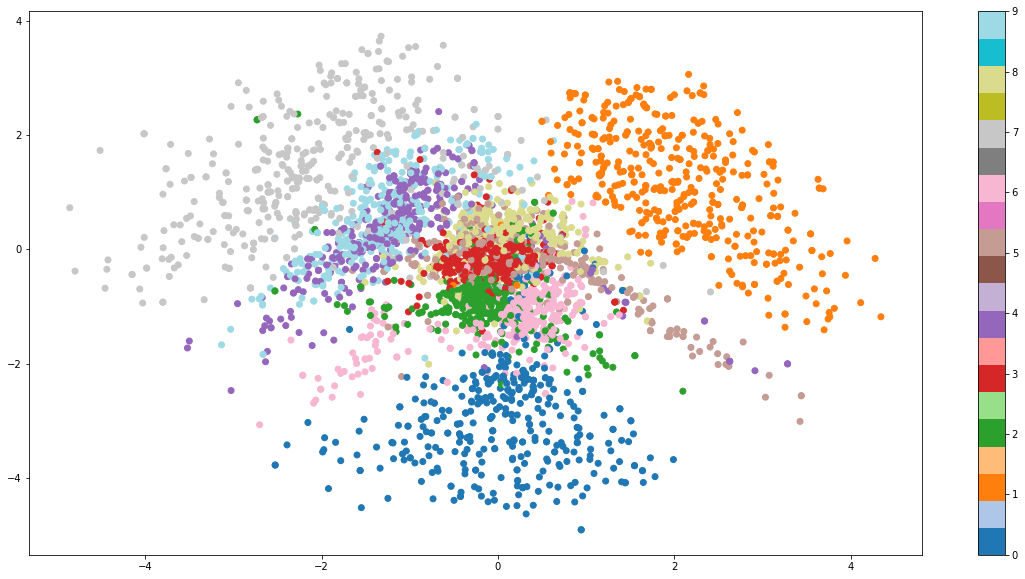

In [15]:
indices = np.random.randint(x_test.shape[0], size=4000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

plt.figure(figsize=(20, 10))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

# Reduce datas with VAE Decoder

In [16]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [17]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

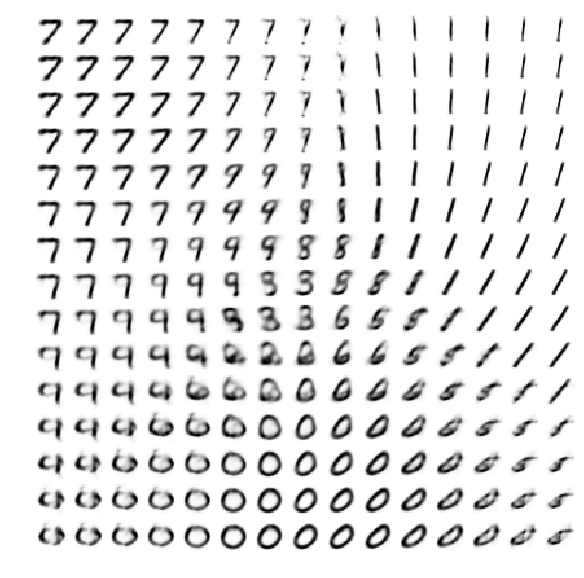

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

# Dynamic results

In [19]:
def inBetween1(first, final):
    t = 1
    idx_1 = np.random.choice(np.where(y_train0 == first)[0])
    idx_2 = np.random.choice(np.where(y_train0 == final)[0])
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t1 = (1-t/4)*x_train0[idx_1] + (t/4) * x_train0[idx_2]
    data_t2 = (1-t/4 * 2)*x_train0[idx_1] + (t/4 * 2) * x_train0[idx_2]
    data_t3 = (1-t/4 * 3)*x_train0[idx_1] + (t/4 * 3) * x_train0[idx_2]
    
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t1 = (1-t/4)*mu_0 + t/4 *mu_1
    mu_t2 = (1-t/4*2)*mu_0 + (t/4*2) *mu_1
    mu_t3 = (1-t/4*3)*mu_0 + (t/4*3) *mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t1[0], mu_t1[1])
    ax1.scatter(mu_t2[0], mu_t2[1])
    ax1.scatter(mu_t3[0], mu_t3[1])

    ax2 = plt.subplot(2, 5, 1)
    ax2.imshow(data_0, cmap='Greys')
    
    ax3 = plt.subplot(2, 5, 2)
    ax3.imshow(data_t1, cmap='OrRd')
    
    ax4 = plt.subplot(2, 5, 3)
    ax4.imshow(data_t2, cmap='YlGnBu')
    
    ax5 = plt.subplot(2, 5, 4)
    ax5.imshow(data_t3, cmap='YlOrRd')

    ax6 = plt.subplot(2, 5, 5)
    ax6.imshow(data_1, cmap='gnuplot2')

In [20]:
interact(inBetween1, first = (0, 9), final = (0, 9))

interactive(children=(IntSlider(value=4, description='first', max=9), IntSlider(value=4, description='final', …

<function __main__.inBetween1(first, final)>